# Ocean Data Challenge Air Quality in Catalonia


According to the European Environemntal Agency "Air pollution is the biggest environmental health risk in Europe Air pollution is hard to escape, no matter where you live. It can seriously affect your health and the environment. Even though air quality in Europe has improved over recent decades, the levels of air pollutants still exceed EU standards and the most stringent World Health Organization guidelines."

The goal of this challenge is to analyze the evolution of air pollution in Catalunya over time and use this information to 
build an algorithm that forecast the concentration of one pollutant in 2 timescale variants:

* Monthly pollutant concentration for the next 2 years.
* Hourly concentration from February 15 to 28. 

The Hourly data for pollutants comes from the automatic measurement points of the Air Pollution Monitoring and Forecasting Network in Catalunya from 1991 until 2023. This data is hosted in the ocean protocol network as a [data asset](https://market.oceanprotocol.com/asset/did:op:4e5040015fd68a5ea61d18c471f164ab531dc6828dde4710d0cdfcdffa62761e)


## Prepare notebook

In [36]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import display

plt.style.use("bmh")
plt.rcParams["figure.figsize"] = [10, 6]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"
sns.set_palette("tab20")

# EDA of data and preprocessing

We will first read the dataset and analyze the available information. Our dataset contains 40 columns and more than 3 million of rows,


In [3]:
data_path = "aqi_data.csv"
df = pd.read_csv(data_path)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3106374 entries, 0 to 3106373
Data columns (total 40 columns):
 #   Column         Dtype  
---  ------         -----  
 0   CODI EOI       int64  
 1   NOM ESTACIO    object 
 2   DATA           object 
 3   MAGNITUD       int64  
 4   CONTAMINANT    object 
 5   UNITATS        object 
 6   TIPUS ESTACIO  object 
 7   AREA URBANA    object 
 8   CODI INE       int64  
 9   MUNICIPI       object 
 10  CODI COMARCA   int64  
 11  NOM COMARCA    object 
 12  01h            float64
 13  02h            float64
 14  03h            float64
 15  04h            float64
 16  05h            float64
 17  06h            float64
 18  07h            float64
 19  08h            float64
 20  09h            float64
 21  10h            float64
 22  11h            float64
 23  12h            float64
 24  13h            float64
 25  14h            float64
 26  15h            float64
 27  16h            float64
 28  17h            float64
 29  18h           

 we're going to group some columns based on the dtypes to ease the posterior access to this data
 

In [4]:
all_columns = set(list(df.columns))

categorical_columns = [
                        'TIPUS ESTACIO',
                       'AREA URBANA',
                       'MUNICIPI',
                       'NOM COMARCA',
                       "NOM ESTACIO"
                      ]


value_columns = [f"0{+1+i}h" if i<9 else f"{1+i}h" for i in range(24)]
id_columns = all_columns.difference(set(value_columns))

for col in categorical_columns:
    df[col] = df[col].astype("category")

Inspecting the categorical columns in our dataset we can see that the data contains 17 pollutants, 3 station types,
3 types of urban area, 76 cities and 31 states.

In [5]:
pollutants = df["CONTAMINANT"].unique()
print(f'Number of pollutants: {pollutants}' )

df[categorical_columns].nunique()


Number of pollutants: ['PM10' 'NOX' 'NO' 'NO2' 'SO2' 'CO' 'O3' 'H2S' 'C6H6' 'PM2.5' 'Hg' 'PM1'
 'Cl2' 'HCT' 'HCNM' 'PS' 'HCl']


TIPUS ESTACIO      3
AREA URBANA        3
MUNICIPI          76
NOM COMARCA       31
NOM ESTACIO      116
dtype: int64

## Global Analysis

1. Analyze the evolution of pollution in Catalunya over time to determine the best/worst hours and best/worst months of the year in terms of pollution, and explain the periodicity of the rate of certain pollutants in the air. 

### Best/Worst Hours

- Taking the hourly mean per each pollutant and then normalizing it to a scale of 0 to 1, will allow us to see how the patterns change in a typical day. We're not taking into account the variation per year, type of station, or urban area but this will allow to see an overview.

- We can see that there are some groups of patterns in terms of the behaviour around the day. 
    
    *   [NO,NOX,CO,HCNM,HCT] -> peaks: 9H and 21H, lows: 16H
    *   [PM10,PS] -> peaks: 10H and 21H, lows: 16H
    *   [PM1,PM25] -> peaks: 1H, 23H, 9H lows: 15H,16H
    *   [03] -> peaks: 16H, lows: 8H
    *   [S02] -> peaks: 11H, 12H, lows: 24:

Text(0, 0.5, 'Normalized concentration')

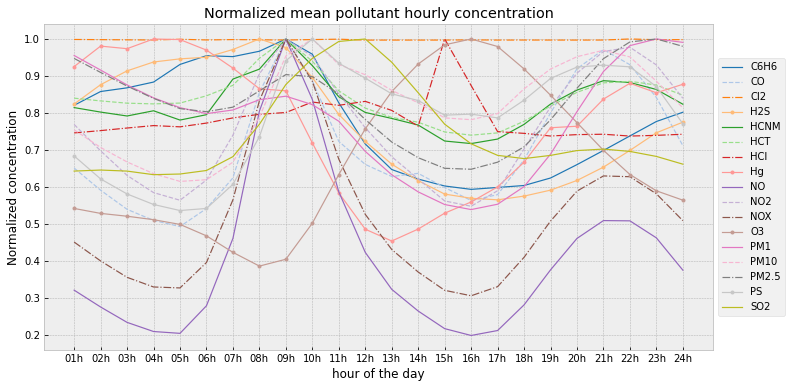

In [6]:
mean_pollutant_hour = df.groupby("CONTAMINANT")[value_columns].agg(np.nanmean)
norm_pollutant_hour = mean_pollutant_hour.divide(np.max(mean_pollutant_hour, axis=1).values , axis=0)
norm_pollutant_hour.T.plot(figsize=(12,6),
                           linewidth=1.2,
                            style=['-', '--', '-.','.-']*4);

plt.xticks([i for i in range(24)],list(norm_pollutant_hour.columns));
plt.title("Normalized mean pollutant hourly concentration")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("hour of the day");
plt.ylabel("Normalized concentration")

The European environmental agency developed an Air Quality Index that is based on concentration values for up to five key pollutants, including:

    * particulate matter (PM10);
    * fine particulate matter (PM2.5);
    * ozone (O3);
    * nitrogen dioxide (NO2);
    * sulphur dioxide (SO2).

We will focus our analysis on those 5 pollutants to explore in a better detail the time evolution 

source: https://airindex.eea.europa.eu/Map/AQI/Viewer/#

In [7]:
eaqui_columns = ['PM2.5','PM10', 'NO2', 'SO2', 'O3']
pm25_bins = [0,10,20,25,50,75,800]
pm10_bins = [0,20,40,50,100,150,1200]
no2_bins = [0,40,90,120,230,340,1000]
o3_bins = [0,50,100,130,240,380,800]
so2_bins = [0,100,200,350,500,750,1250]

eaqui_labels = ["good","fair","moderate","poor","very poor","extremely poor"]
df_eaqui = df[df["CONTAMINANT"].isin(eaqui_columns)].copy()
df_eaqui = df_eaqui.dropna()

del df

Text(0.5, 0, 'hour of the day')

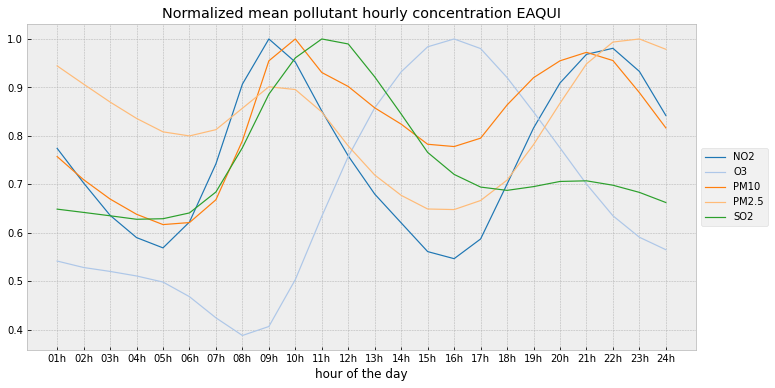

In [8]:

mean_pollutant_hour = df_eaqui.groupby("CONTAMINANT")[value_columns].mean()
norm_pollutant_hour = mean_pollutant_hour.divide(np.max(mean_pollutant_hour, axis=1).values , axis=0)
norm_pollutant_hour.T.plot(figsize=(12,6),
                           linewidth=1.2);


plt.xticks([i for i in range(24)],list(mean_pollutant_hour.columns));
plt.title("Normalized mean pollutant hourly concentration EAQUI")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel("hour of the day")

We can make boxplots to see the range of variation of the data on each pollutant

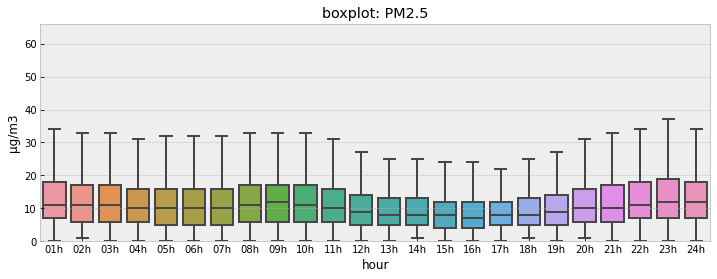

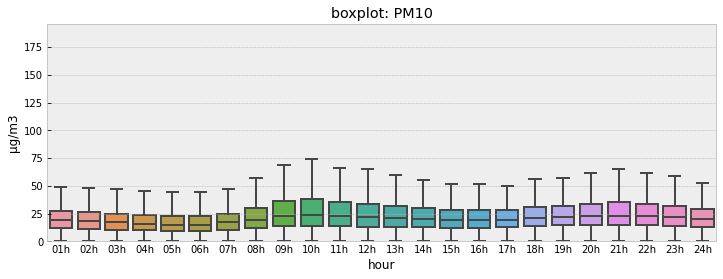

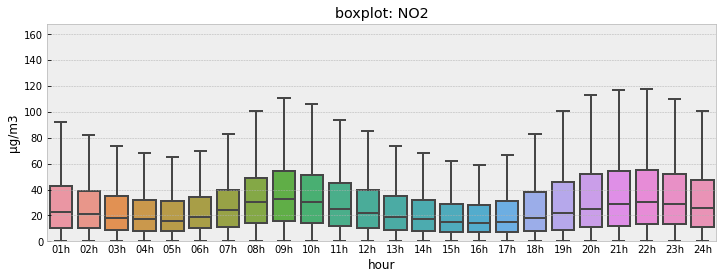

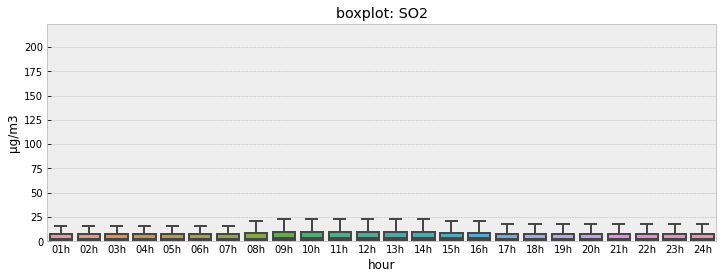

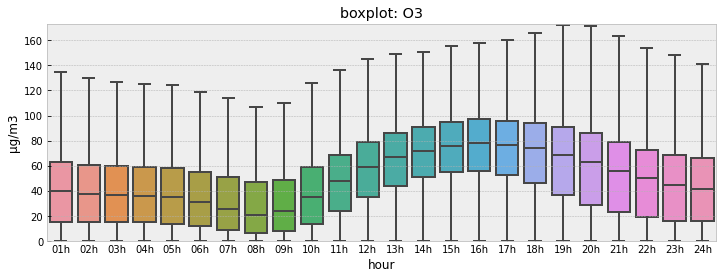

In [9]:
for pollutant in eaqui_columns:
    plt.figure(figsize=(12,4))
    df_filt = df_eaqui[df_eaqui["CONTAMINANT"].isin([pollutant])]
    #print(np.quantile(df_filt[value_columns].values,0.9,23))
    sns.boxplot(data=df_filt[value_columns], showfliers=False);
    plt.autoscale(tight=True)
    plt.title(f"boxplot: {pollutant}")
    ylimit = np.max(np.quantile(df_filt[value_columns].dropna(),0.998,axis=0))
    plt.ylim([0,ylimit])
    plt.xlabel("hour")
    plt.ylabel(f'{df_filt["UNITATS"].sample(1).values[0]}')
    plt.show()

### *Best/Worst Months*

We can plot the heatmap of the hourly average concentration value per month using the 5 pollutants of the EAQI index. there are some interesting patterns on each pollutant:

* PM2.5: Worst months are January, February, March and December, the peaks at 10H at the begining year moves towards 8H on June and July;Also the peaks at 21H
 at the begining year moves towards 2H on June and July.
* PM10: Worst months are February, July and October. Peaks at 10H on february moves towards 9H on July.
* NO2: Worst months are Febrary November and December. It Also has seasonality component similar to PM2.5
* SO2: Worst months are January, February and December
* 03: Worst month is July and the other summer months, Peaks are at 16h and it get wider on July. High values start from april to September 

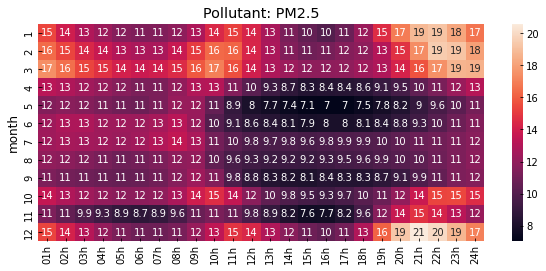

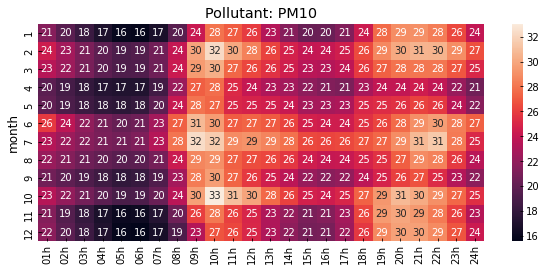

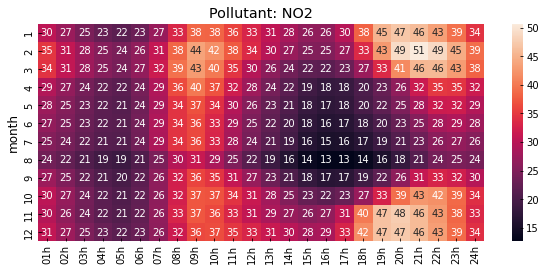

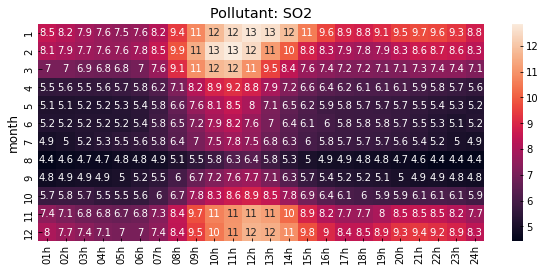

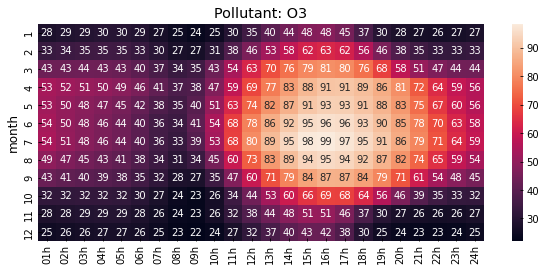

In [10]:
df_eaqui["month"] = pd.to_datetime(df_eaqui["DATA"],format="%d/%m/%Y") \
                    .dt.month

df_month = pd.DataFrame()
for pollutant in eaqui_columns:
    df_filt = df_eaqui[df_eaqui["CONTAMINANT"].isin([pollutant])]
    mean_months = df_filt.groupby(["month"])[value_columns].mean()
    max_month = (pd.DataFrame(mean_months.max(axis=1).reset_index())
                 .assign(contaminant=pollutant))
    df_month = pd.concat([df_month,max_month])
    plt.figure(figsize=(10,4))
    sns.heatmap(mean_months,annot=True)
    plt.title(f"Pollutant: {pollutant}")
    plt.show()

finally we can see a summary in the following table with the best/worsth monmth per pollutant

In [38]:
display(pd.pivot_table(df_month,columns="month",index="contaminant")\
    .round(2).style \
        .format(precision=2) \
        .background_gradient(axis=1))

2. Analyze the relationship between altitude and concentration of particles in the air, and present your conclusions in graphical form.

From the distribution of O3 values it seems that the relation with the altitude follows a negative correlation, but it is not clear cause in the scatter plot there is a lot of dispersion

In [12]:
particle_columns = ["PM2.5","PM10"]

df_particle = df_eaqui[df_eaqui["CONTAMINANT"].isin(particle_columns)].copy()
df_particle = df_particle.dropna()
df_long_particle = pd.melt(df_particle,value_vars=value_columns,id_vars=["ALTITUD","CONTAMINANT","TIPUS ESTACIO","AREA URBANA"])

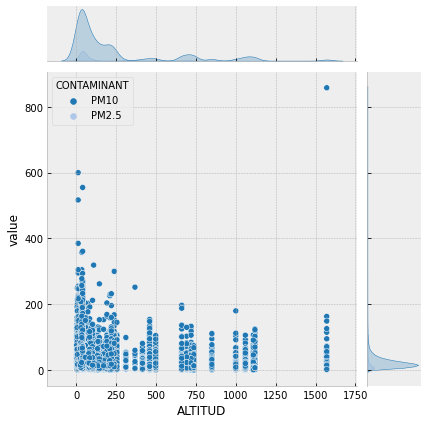

In [15]:
df_sample = df_long_particle.sample(100000)
sns.jointplot(data=df_sample,x="ALTITUD",y="value",hue="CONTAMINANT");

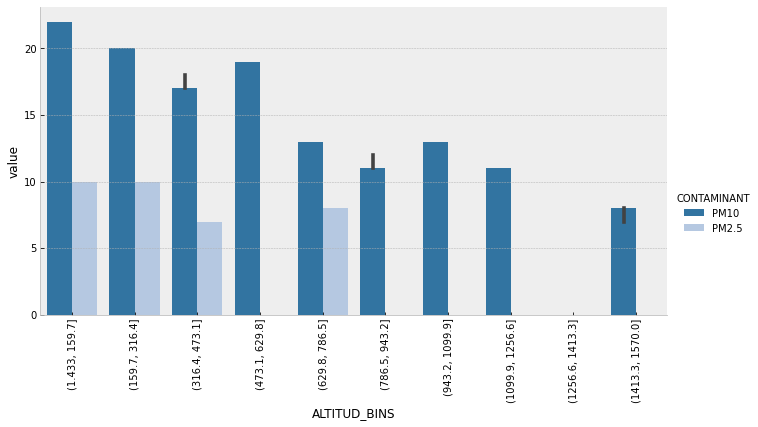

In [27]:

df_long_particle["ALTITUD_BINS"] = pd.cut(df_long_particle["ALTITUD"],bins=10)
sns.catplot(data=df_long_particle,x="ALTITUD_BINS",y="value",aspect=1.9,kind="bar",estimator=np.median,hue="CONTAMINANT")
plt.xticks(rotation=90);

3. Analyze the concentration of pollutants in urban, suburban and rural areas, and present your conclusion in graphical form.

*   For the contaminants PM10 and NO2 is clear to see how  mean levels increase from rural to urban areas.
*   The case for O3 is the opposite as it has higher average concentration levels on rural areas, and lower levels on urban ones. 

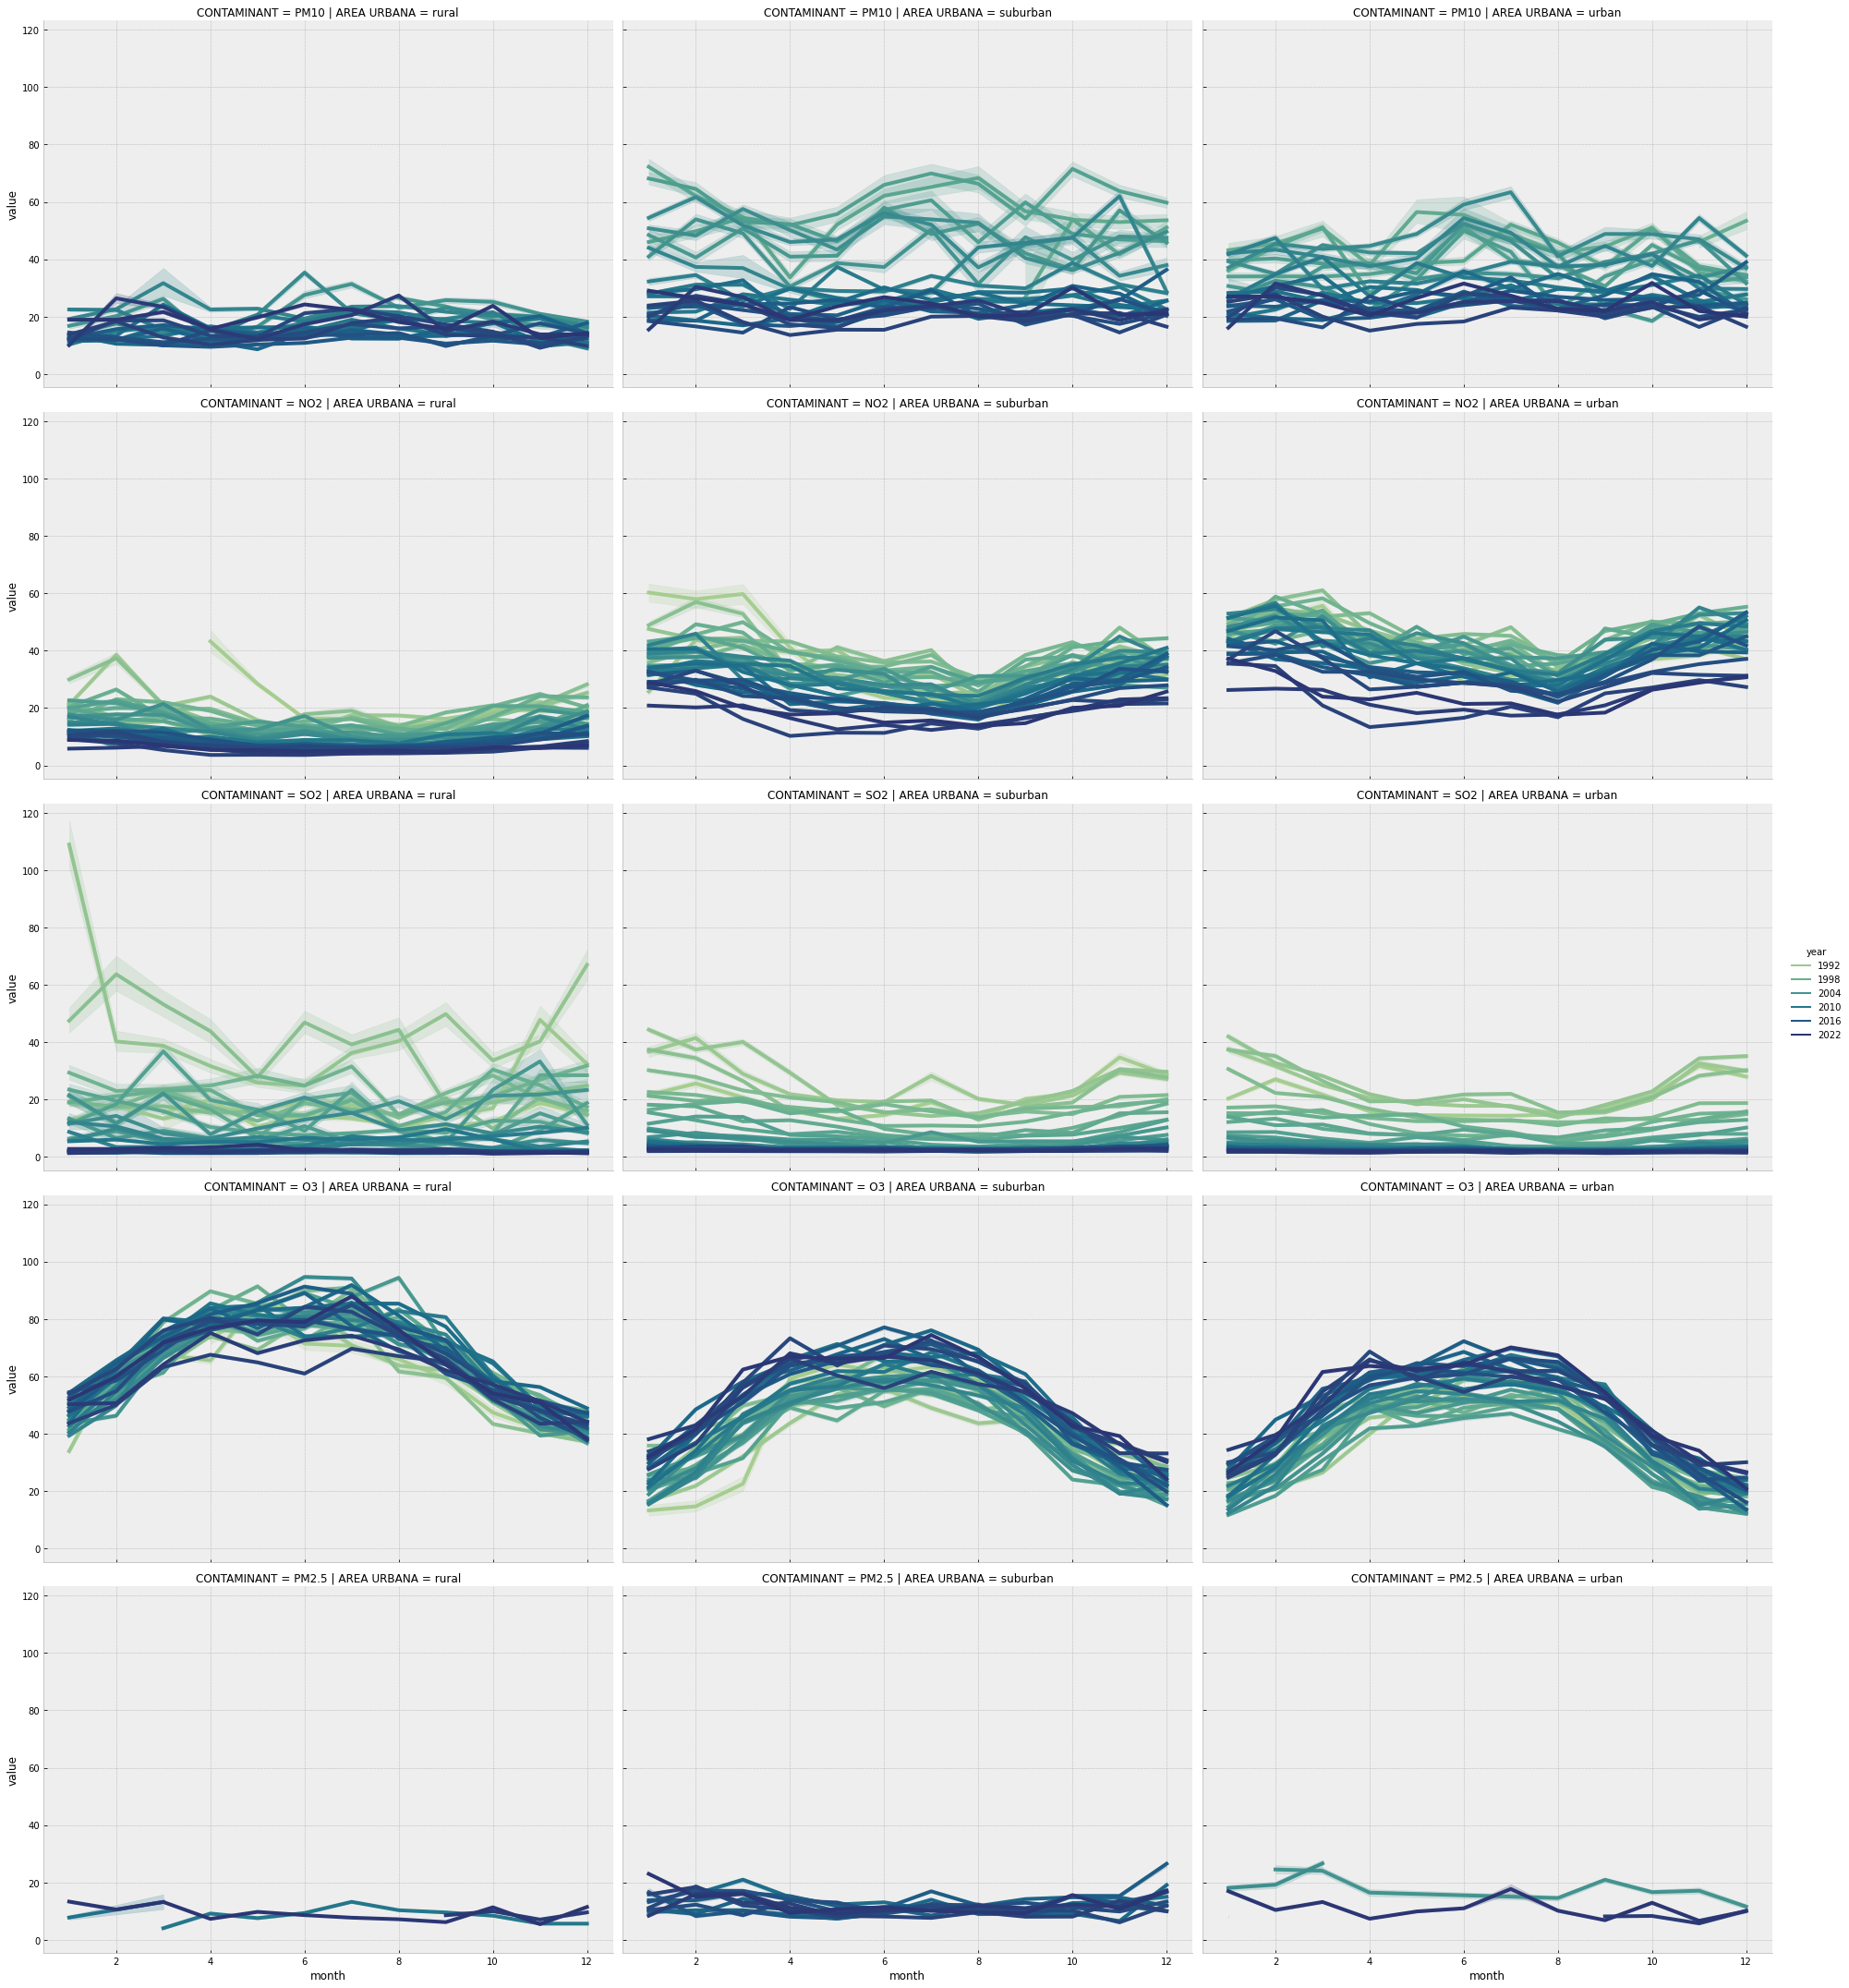

In [14]:
df_long = pd.melt(df_eaqui,id_vars=id_columns,value_vars=value_columns)

df_long["hour"] = df_long["variable"].str.replace("h","") \
                    .str.replace("24","00")

df_long["datetime"] = pd.to_datetime(df_long["DATA"] + " " + df_long["hour"],format="%d/%m/%Y %H")
df_long = df_long.drop(columns=["variable","DATA","hour"])

df_long["month"] = df_long["datetime"].dt.month
df_long["year"] = df_long["datetime"].dt.year

g = sns.relplot(
    data=df_long,
    x="month", y="value", row="CONTAMINANT", hue="year",
    kind="line", palette="crest", linewidth=4, zorder=5,
    col="AREA URBANA", height=6, aspect=1.5, legend=True,
)
del df_long

4. Rank the cities in the dataset according to their level of pollution, and create best-5 and worst-5 lists. 

We will use the European Air quality index to sort the pollution in the catalonian cities, there are a lot of cities that don't have complete data so we will present top 5/ worst five for all the cities, and also for the cities that have information on all the contaminants

In [34]:
bins_dict = {'PM2.5': pm25_bins,
             'PM10': pm10_bins,
             'NO2': no2_bins,
             'SO2': so2_bins,
            'O3': o3_bins}
aq_cols = []

df_concat = pd.DataFrame()
for pollutant in eaqui_columns:
    df_temp = df_eaqui[df_eaqui["CONTAMINANT"].isin([pollutant])].copy()
    index_col = f"AQ_Index_{pollutant}"
    aq_cols.append(index_col)
    # Get the max value of the pollutant on the day and map into the bin levels of the European Air quality index
    df_temp[index_col] = pd.cut(df_temp[value_columns].max(axis=1), bins=bins_dict[pollutant],labels=[0,1,2,3,4,5])
    df_temp = df_temp.dropna(subset=[index_col])
    df_temp[index_col] = df_temp[index_col].astype(int)
    df_grouped = df_temp.groupby("MUNICIPI").agg({f"AQ_Index_{pollutant}": "mean"})
    df_concat = pd.concat([df_concat, df_grouped],axis=1)

# get the max of each of the 5 pollutants
df_concat["EAQUI"] = df_concat[aq_cols].max(axis=1)
print("least polluted")
print(df_concat["EAQUI"].sort_values()[0:5])
print("most polluted")
print(df_concat["EAQUI"].sort_values()[-6:-1])

least polluted
MUNICIPI
Ripollet                        0.017301
Montornès del Vallès            0.030606
Alcanar                         0.138602
Sitges                          0.293992
Santa Margarida i els Monjos    0.474328
Name: EAQUI, dtype: float64
most polluted
MUNICIPI
Montcada i Reixac          2.199660
Mollet del Vallès          2.200000
Sant Vicenç dels Horts     2.587739
Sant Andreu de la Barca    3.471392
Gavà                       4.445833
Name: EAQUI, dtype: float64


In [39]:
display(df_concat.dropna().sort_values("EAQUI",ascending=False).style.background_gradient(cmap="magma").format(precision=2))

,AQ_Index_PM2.5,AQ_Index_PM10,AQ_Index_NO2,AQ_Index_SO2,AQ_Index_O3,EAQUI
MUNICIPI,,,,,,
Sant Andreu de la Barca,1.71,3.47,1.18,0.01,0.81,3.47
Mollet del Vallès,2.20,1.93,1.60,0.02,0.79,2.20
Barcelona,1.80,2.14,1.31,0.01,0.92,2.14
Vila-seca,1.85,1.36,0.78,0.00,1.27,1.85
Igualada,1.57,1.64,0.74,0.20,1.20,1.64
Tarragona,1.51,1.35,0.81,0.03,1.27,1.51
Montseny,0.97,0.43,0.01,0.00,1.49,1.49
Perafort,1.30,1.04,0.21,0.07,1.39,1.39


To have an overview of the dataset, lets plot the time series of each pollutant to see how the values have changed on the course of 31 years. we're going to reformat this dataset into a long format that is more convenient when we create the foracast model. 

In [18]:

def plot_year_time_series(df_long, pollutant):
    # Plot each year's time series in its own facet
    # source: https://seaborn.pydata.org/examples/timeseries_facets.html
    sns.set_theme(style="dark")
    g = sns.relplot(
        data=df_long,
        x="month", y="value", col="year", hue="year",
        kind="line", palette="crest", linewidth=4, zorder=5,
        col_wrap=5, height=2.5, aspect=1.5, legend=False,
    )
    # Iterate over each subplot to customize further
    for year, ax in g.axes_dict.items():

        # Add the title as an annotation within the plot
        ax.text(.8, .85, year, transform=ax.transAxes, fontweight="bold")

    # Tweak the supporting aspects of the plot
    g.set_titles("")
    g.set_axis_labels("", pollutant)
    g.tight_layout()
    plt.show()
    plt.close()

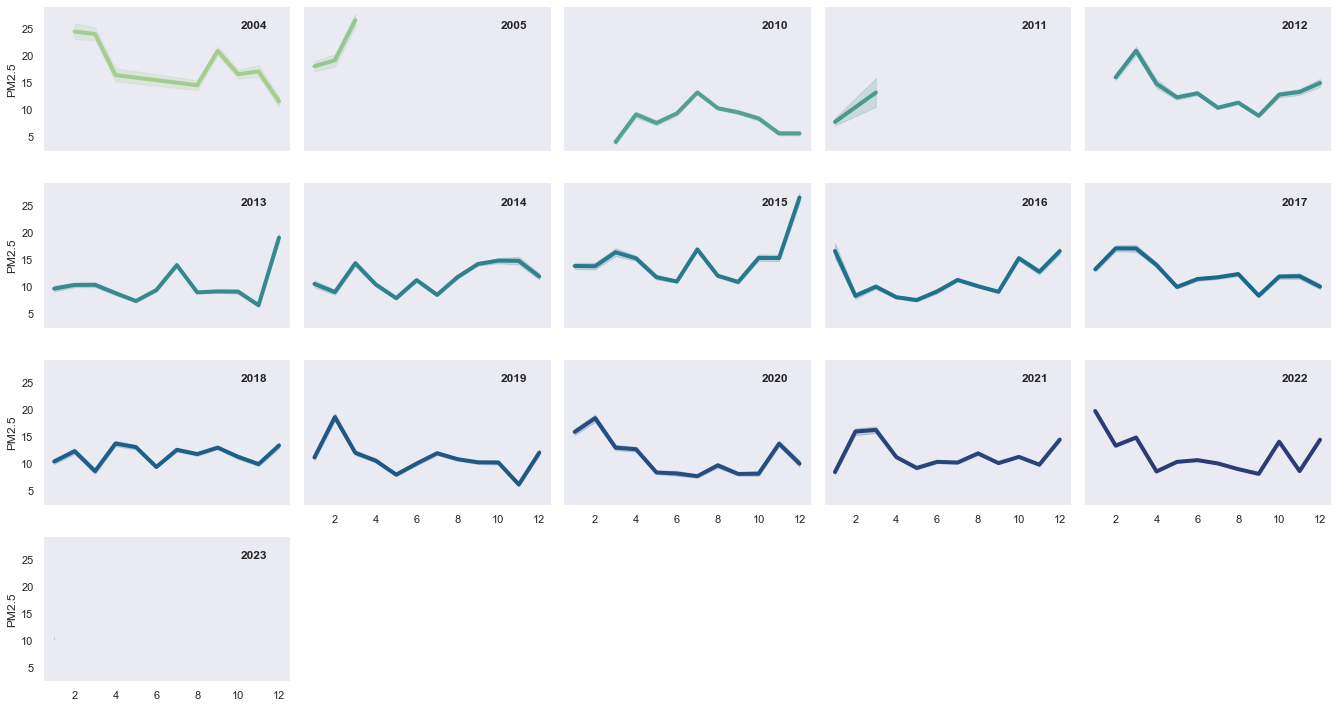

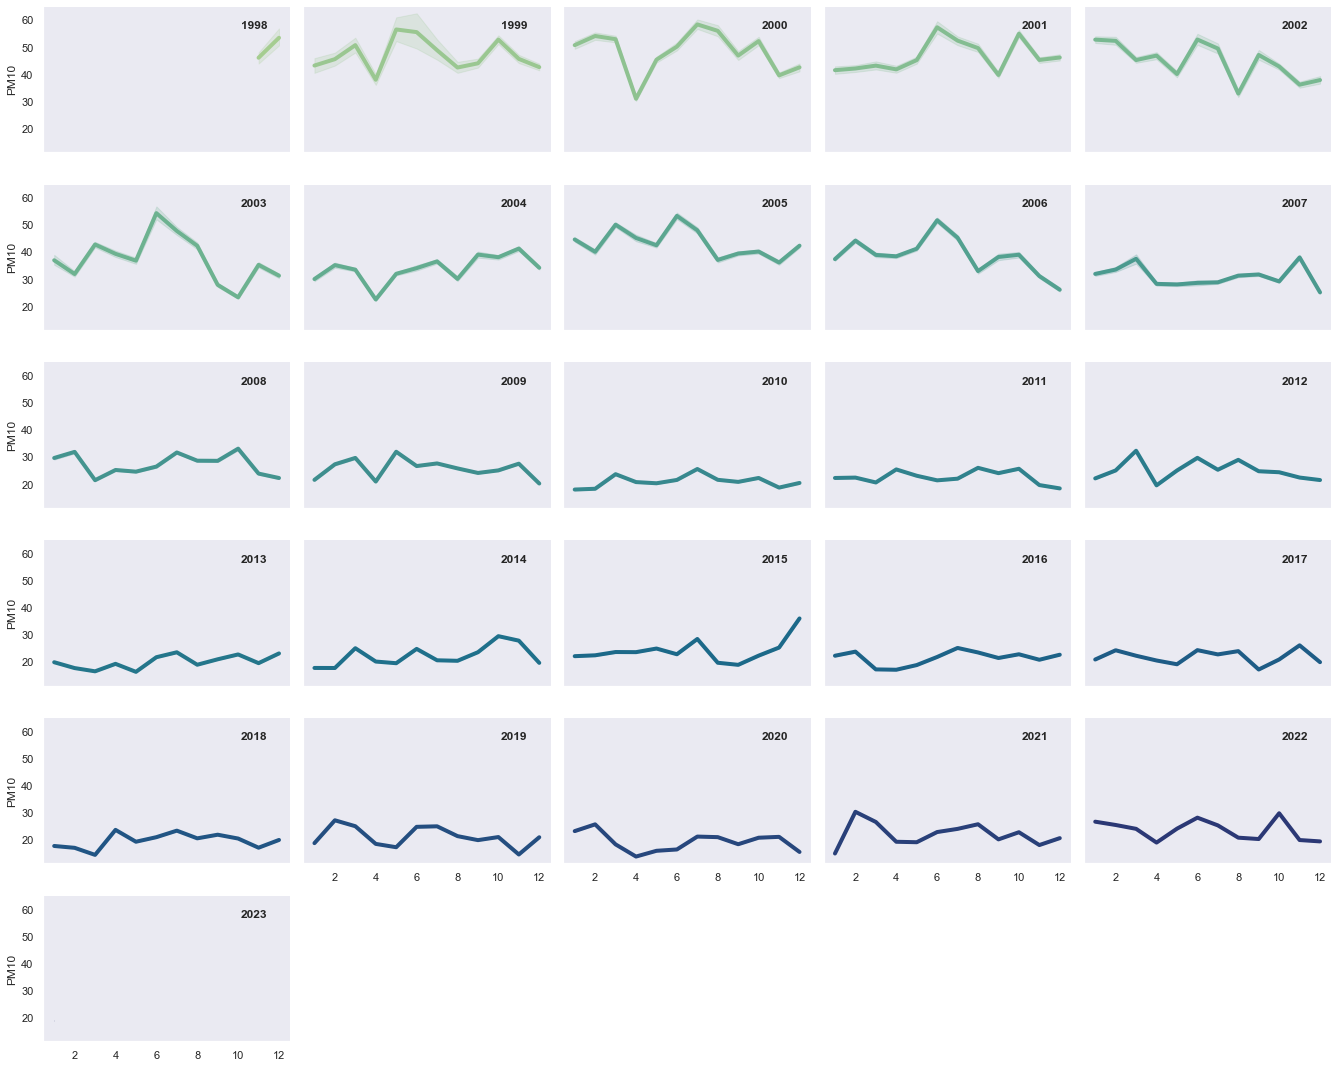

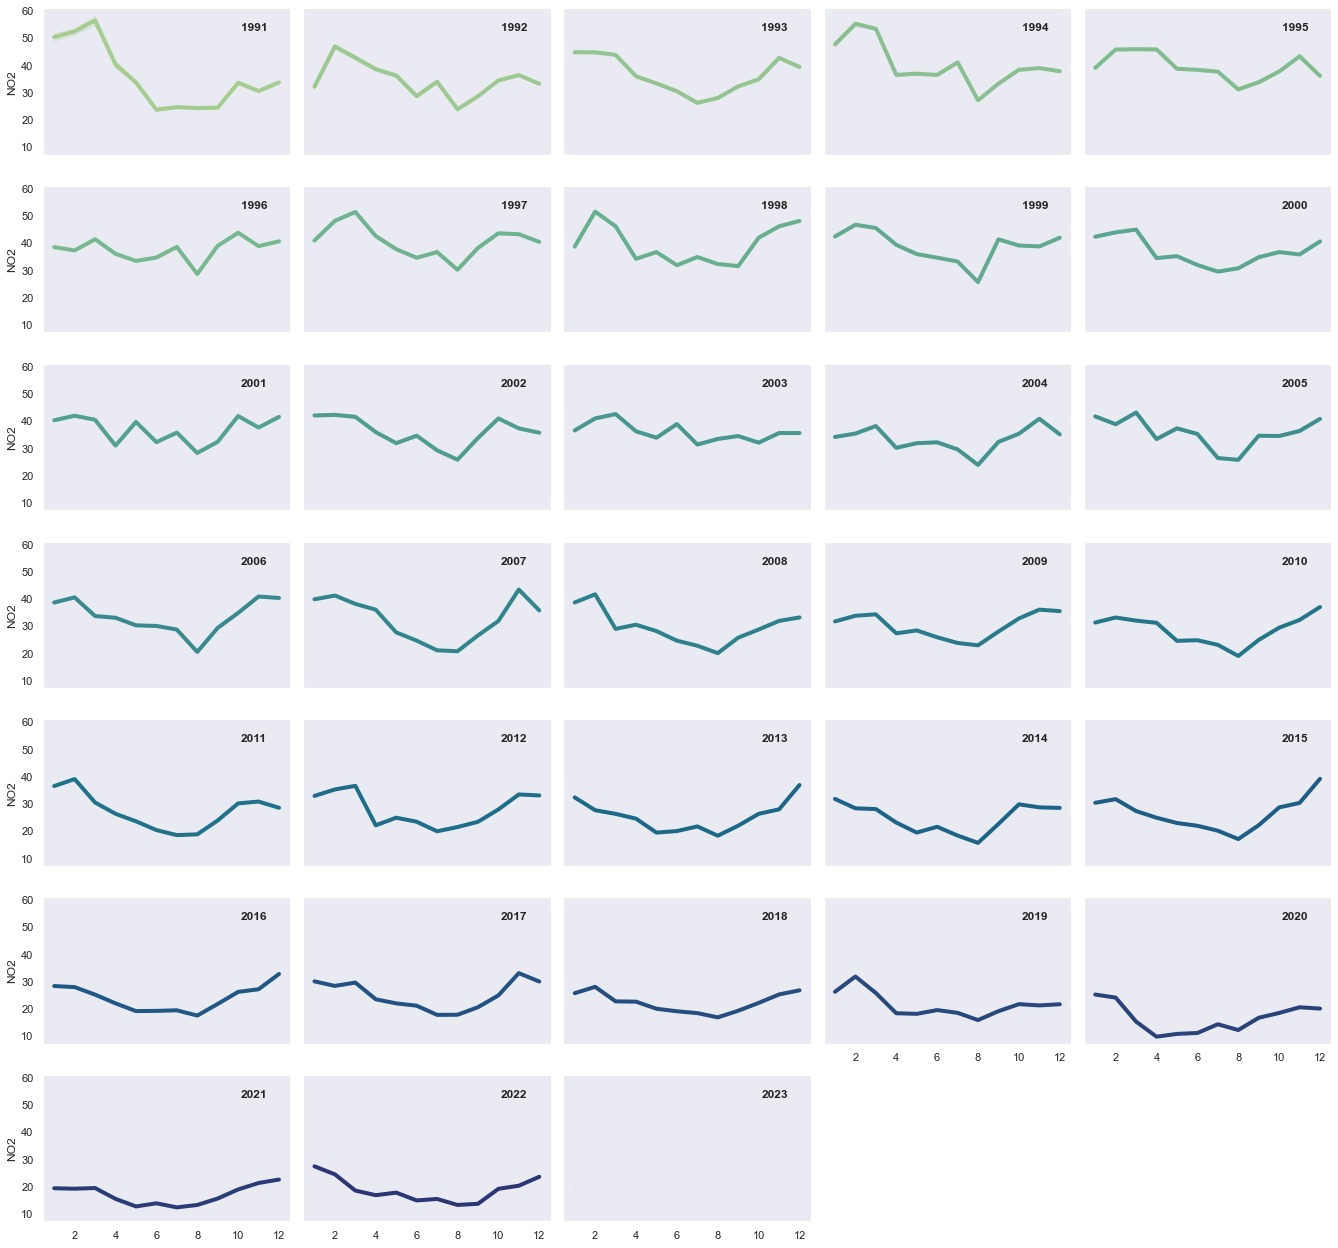

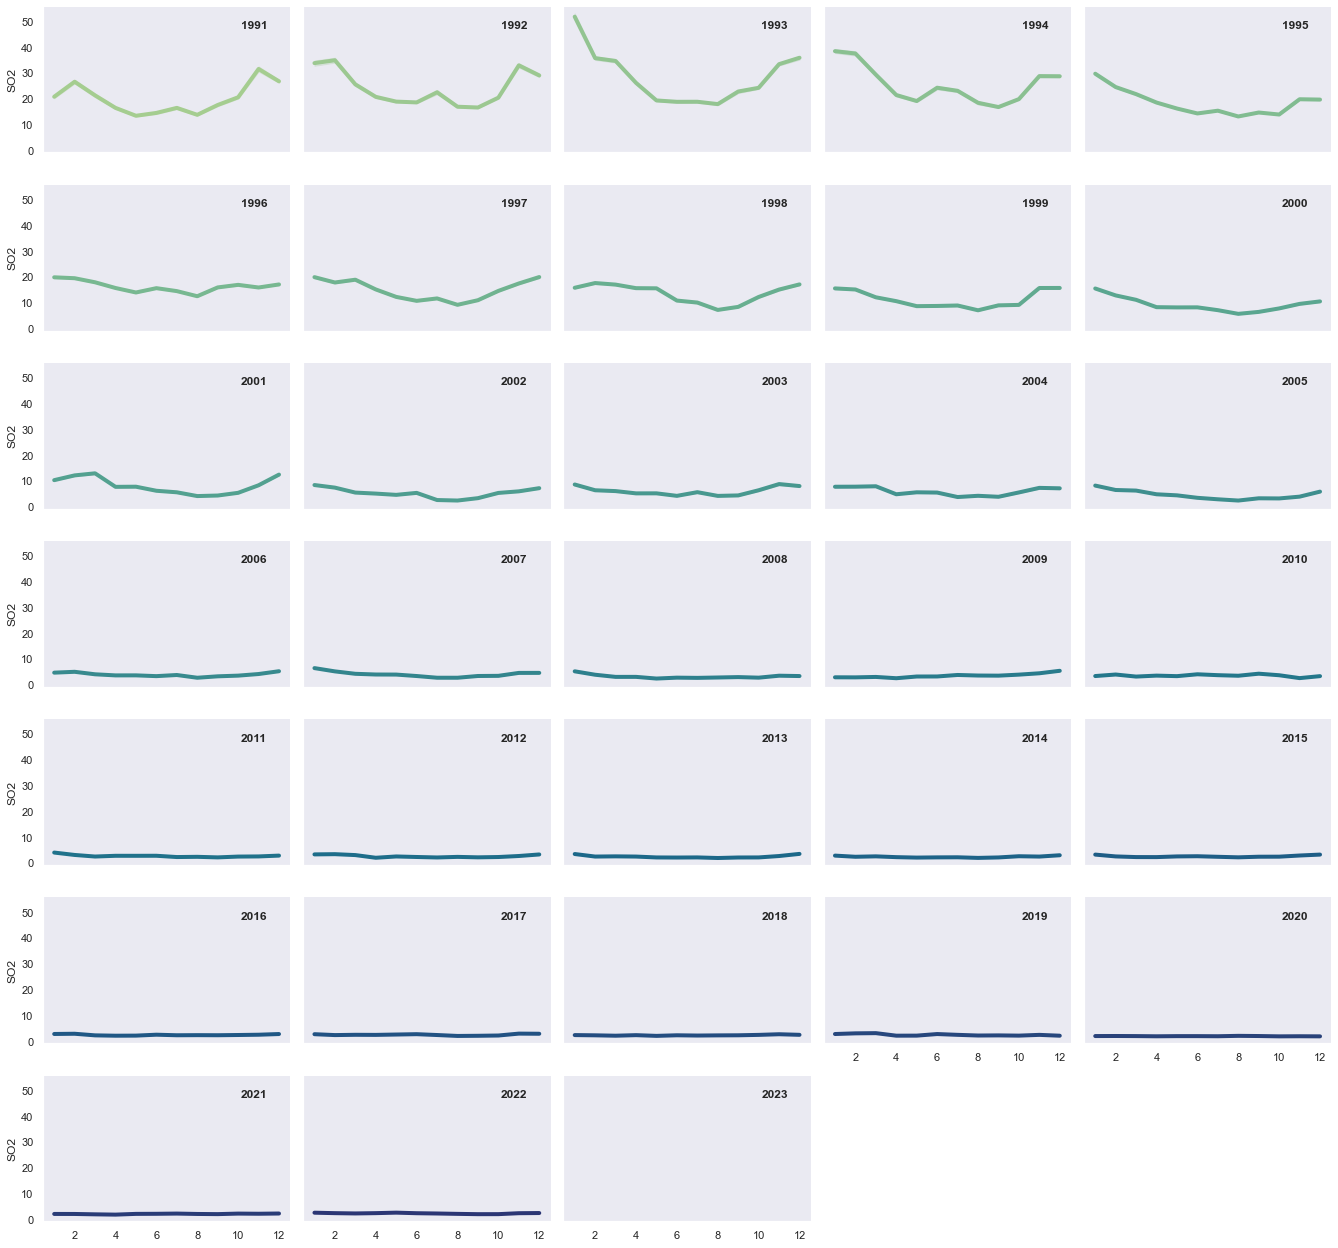

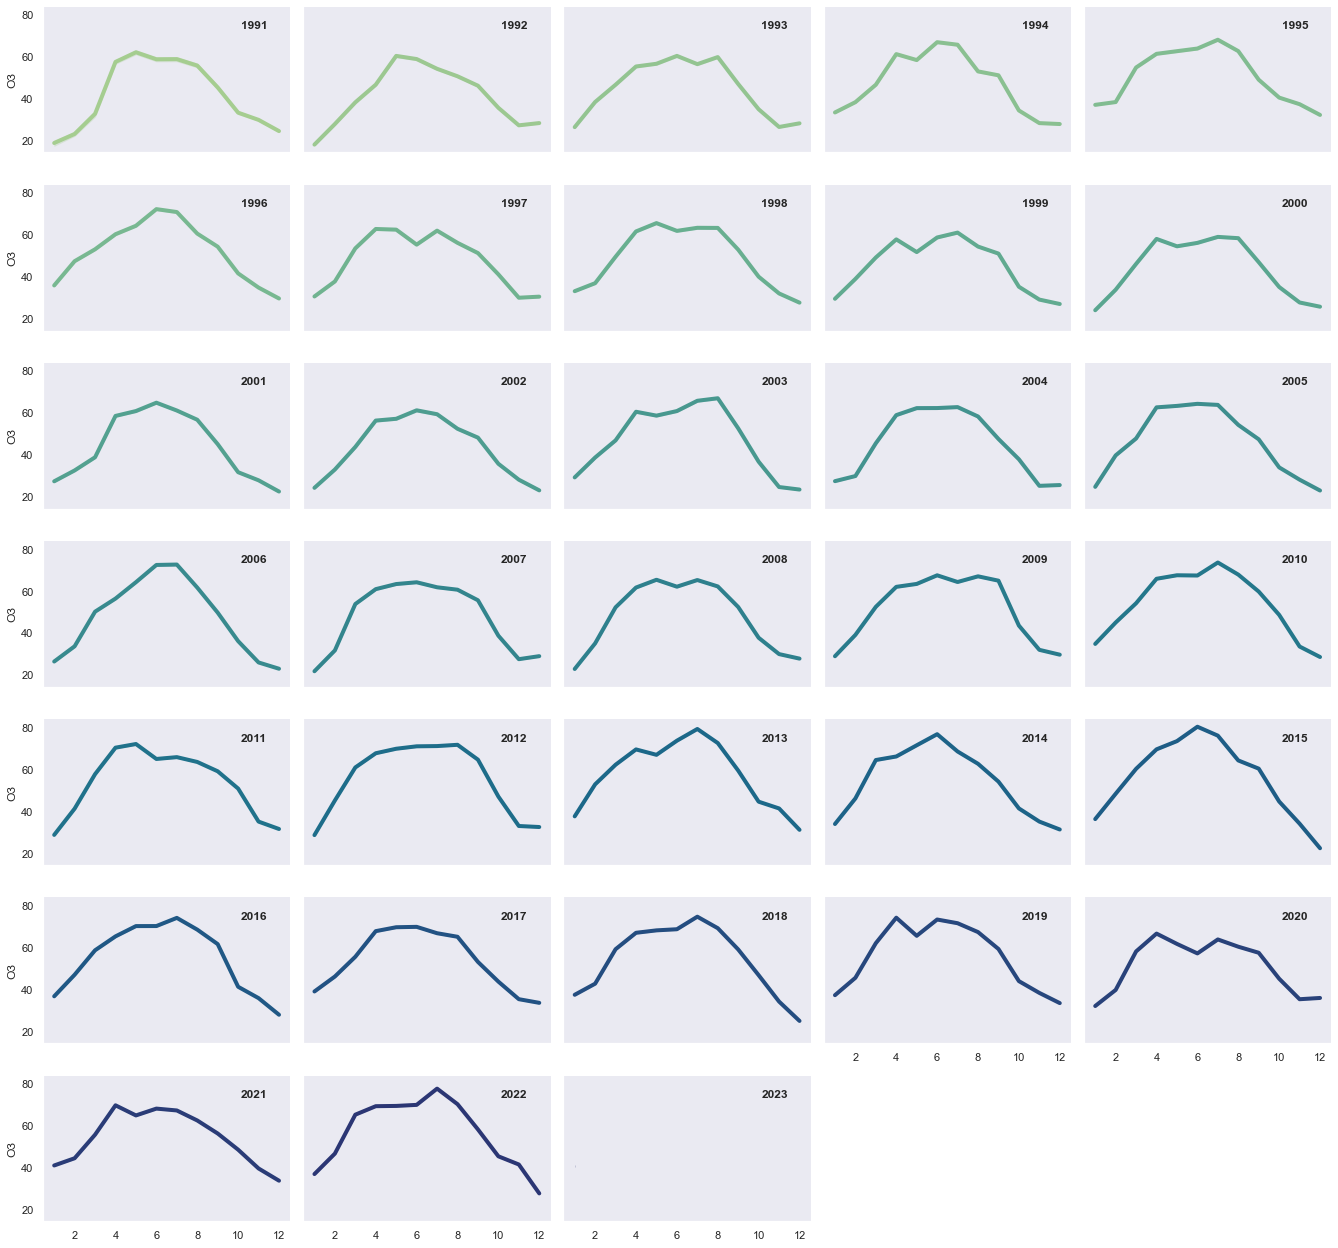

In [19]:

for pollutant in eaqui_columns:
    df_temp = df_eaqui[df_eaqui["CONTAMINANT"].isin([pollutant])].copy()

    df_long = pd.melt(df_temp,id_vars=id_columns,value_vars=value_columns)

    df_long["hour"] = df_long["variable"].str.replace("h","") \
                        .str.replace("24","00")

    df_long["datetime"] = pd.to_datetime(df_long["DATA"] + " " + df_long["hour"],format="%d/%m/%Y %H")
    df_long = df_long.drop(columns=["variable","DATA","hour"])

    df_long["month"] = df_long["datetime"].dt.month
    df_long["year"] = df_long["datetime"].dt.year

    plot_year_time_series(df_long=df_long, pollutant=pollutant)

## Forecast Algorithms

We choose O3 as the pollutant to make the forecast, as it seems that levels have risen from 1991 to the current year, and the behaviour on the month has a strong seasonality component that can be modeleded with a time-series model.

In [20]:
pollutant = "O3"
filename = data_path
df = pd.read_csv(filename, header=0)

# helper columns
all_columns = df.columns
value_columns = [f"0{+1+i}h" if i<9 else f"{1+i}h" for i in range(24)]
id_columns = all_columns.difference(set(value_columns))

# Filt df
df_filt = df[df["CONTAMINANT"].isin([pollutant])]
del df

## wide 2 long
df_long = pd.melt(df_filt,id_vars=id_columns,value_vars=value_columns)
df_long["hour"] = df_long["variable"].str.replace("h","").str.replace("24","00")
df_long["datetime"] = pd.to_datetime(df_long["DATA"] + " " + df_long["hour"],format="%d/%m/%Y %H")
df_long = df_long.drop(columns=["variable",
                                "DATA",
                                "hour",
                                "GEOREFERENCIA",
                                "NOM COMARCA",
                                ])

df_long = df_long.dropna()

# add datime columns
df_long["hour"] = df_long["datetime"].dt.hour
df_long["day"] = df_long["datetime"].dt.day
df_long["weekday"] = df_long["datetime"].dt.dayofweek
df_long["month"] = df_long["datetime"].dt.month
df_long["year"] = df_long["datetime"].dt.year

# sort values
df_long = df_long.sort_values(by="datetime")

numeric_features =["ALTITUD",
                  "LONGITUD",
                  "LATITUD",
                  ]

categorical_features =["hour","day","weekday","month","year"]
string_features = ["AREA URBANA", "TIPUS ESTACIO"]
target = "value"

for col in categorical_features:
    df_long[col] = df_long[col].astype("category")

for col in string_features:
    df_long[col] = df_long[col].astype("category")
    df_long[col] = df_long[col].cat.codes
    

By plotting the time-series we can see that not all of the stations have information in all of the measurement period. 

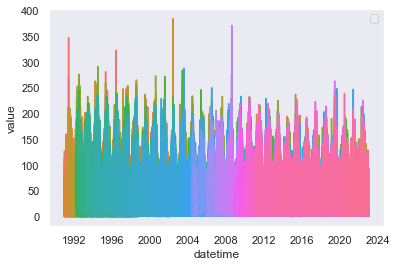

In [22]:
sns.lineplot(data=df_long,
             x="datetime",
             y="value",
             hue="NOM ESTACIO",
             )

plt.legend("")

there are even some stations that have as low as 72 points, so the estimates for the predicitons for this stati

<AxesSubplot:ylabel='NOM ESTACIO'>

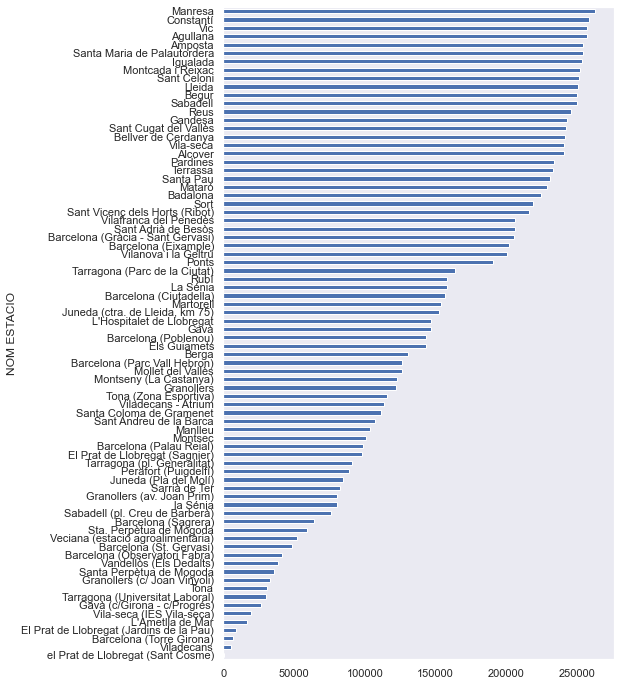

In [23]:
df_long.groupby("NOM ESTACIO").count()["value"].sort_values(ascending=True).plot(kind="barh",figsize=(7,12))

from the correlation plot there seems to be a weak correlation of the O3 levels with the altitude

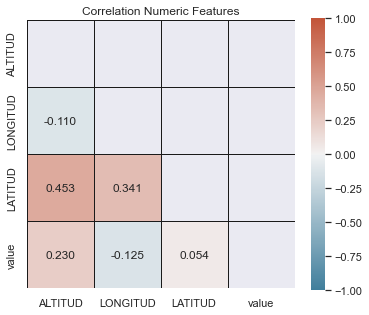

In [24]:

corr_df = df_long[numeric_features + [target]].corr()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
mask = np.triu(np.ones_like(corr_df, dtype=bool))

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    data=corr_df,
    mask=mask,
    cmap=cmap, 
    vmax=1.0, 
    vmin=-1.0,
    center=0,
    square=True, 
    linewidths=0.5, 
    linecolor='k',
    annot=True, 
    fmt='.3f',
    ax=ax
)
ax.set(title='Correlation Numeric Features');

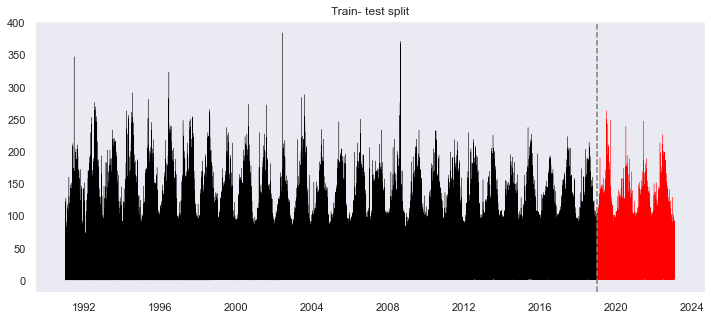

In [25]:
train_df = df_long[df_long.datetime < "2019-01-01 00:00:00"]
test_df = df_long[df_long.datetime > "2019-01-01 00:00:00"]

fig, ax = plt.subplots()
fig.set_size_inches((12,5))
ax.plot(train_df.datetime, train_df.value, color='black',linewidth=0.3)
ax.plot(test_df.datetime, test_df.value, color="red",linewidth=0.3)
ax.axvline(x=test_df.datetime.iloc[0], color='gray', linestyle='--', label='train-test-split')
ax.set_title("Train- test split");


## Forecast using hist gradient Booster




In [26]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import PartialDependenceDisplay


x_train = train_df[numeric_features + categorical_features + string_features]
y_train = train_df[target]
x_test = test_df[numeric_features + categorical_features + string_features]
y_test = test_df[target]

model = HistGradientBoostingRegressor(loss="squared_error",
                                      categorical_features=[8,9])

model.fit(x_train,y_train)
model.score(x_test,y_test)

0.6014400716040391

In [27]:
y_pred = model.predict(x_test)
print(f"MSE: {round(mean_squared_error(y_true=y_test,y_pred=y_pred),2)} ",)

MSE: 386.04 


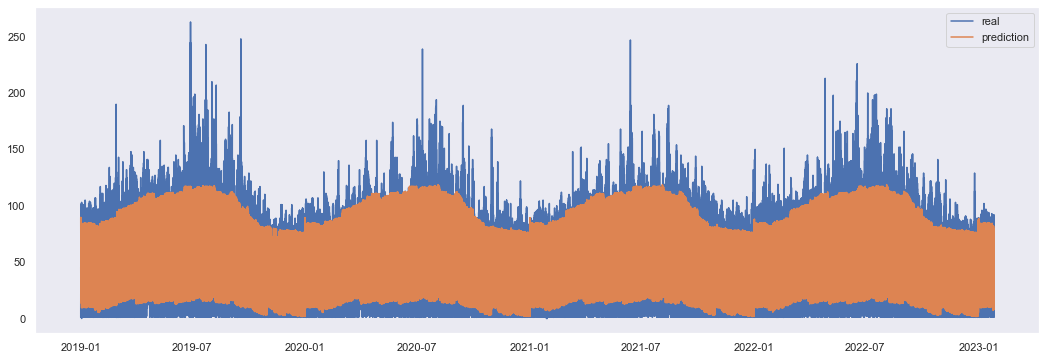

In [28]:
fig, ax = plt.subplots()
fig.set_size_inches((18,6))
ax.plot(test_df.datetime,y_test.values)
ax.plot(test_df.datetime,y_pred)

plt.legend(["real","prediction"])

## Model interpretation

From the dependency plot obtained from the model, it can be seen that the features that make a great impact in the model are the hour and the month. There seems to be also a dependency with altitude and the weekend days. The year feature follows an upward trend. Lastly the type of station does not influence the prediction, however the Area  

Computing partial dependence plots...


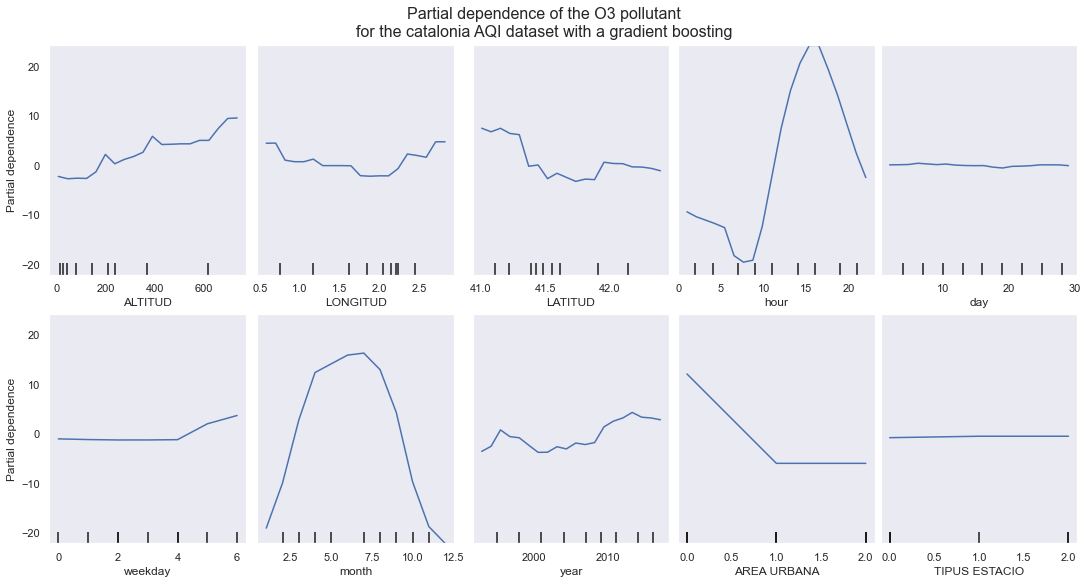

In [29]:
print("Computing partial dependence plots...")

common_params = {
    "subsample": 50,
    "n_jobs": 2,
    "grid_resolution": 20,
    "random_state": 0,
}

features_info = {
    # features of interest
    "features": numeric_features + categorical_features + string_features,
    # type of partial dependence plot
    "kind": "average",
}
fig, ax = plt.subplots(ncols=5, nrows=2, figsize=(9, 8), constrained_layout=True)
display = PartialDependenceDisplay.from_estimator(
    model,
    x_train,
    **features_info,
    ax=ax,
    **common_params,
)
_ = display.figure_.suptitle(
    "Partial dependence of the O3 pollutant\n"
    "for the catalonia AQI dataset with a gradient boosting",
    fontsize=16,
)

fig.set_size_inches((15,8))


let's retrain without the type of area and station

In [30]:
x_train = train_df[numeric_features + categorical_features]
y_train = train_df[target]
x_test = test_df[numeric_features + categorical_features]
y_test = test_df[target]

model = HistGradientBoostingRegressor(loss="squared_error",
                                      learning_rate=0.05,
                                        validation_fraction=0.15,
                                        max_iter=200)

model.fit(x_train,y_train)
print(f"Test score R2: {model.score(x_test,y_test)}")

Test score R2: 0.6057280866774697


## Future Hourly predictions

Text(0.5, 1.0, 'Forecast of Mean O3 levels from 2023/02/15 00:00:00 to 2023/02/28 00:00:00')

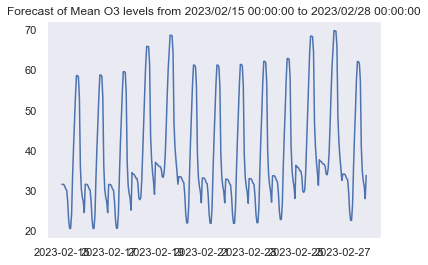

In [31]:
## hourly predictions

start_date = "2023/02/15 00:00:00"
end_date = "2023/02/28 00:00:00"

dates = pd.date_range(start=start_date,
              end=end_date,
              freq="H")

df_forecast = pd.DataFrame(dates,columns=["datetime"])

# add datime columns
df_forecast["hour"] = df_forecast["datetime"].dt.hour
df_forecast["day"] = df_forecast["datetime"].dt.day
df_forecast["weekday"] = df_forecast["datetime"].dt.dayofweek
df_forecast["month"] = df_forecast["datetime"].dt.month
df_forecast["year"] = df_forecast["datetime"].dt.year

for feature in numeric_features:
    df_forecast[feature] = df_long[feature].median()

df_forecast["O3_forecast"] = model.predict(df_forecast[numeric_features + categorical_features])
plt.plot(df_forecast["datetime"].values,df_forecast["O3_forecast"].values)
plt.title(f"Forecast of Mean O3 levels from {start_date} to {end_date}")


# Forecast Month

We will folow the same approach as that we used on the dataframe, but this time we're going to use just the month and year information as the prediction now does not have to be on a fine time-scale

In [32]:
pollutant = "O3"
filename = data_path
df = pd.read_csv(filename, header=0)

# helper columns
all_columns = df.columns
value_columns = [f"0{+1+i}h" if i<9 else f"{1+i}h" for i in range(24)]
id_columns = all_columns.difference(set(value_columns))

# Filt df
df_filt = df[df["CONTAMINANT"].isin([pollutant])]
del df

## wide 2 long
df_long = pd.melt(df_filt,id_vars=id_columns,value_vars=value_columns)
df_long["hour"] = df_long["variable"].str.replace("h","").str.replace("24","00")
df_long["datetime"] = pd.to_datetime(df_long["DATA"] + " " + df_long["hour"],format="%d/%m/%Y %H")
df_long = df_long.drop(columns=["variable",
                                "DATA",
                                "hour",
                                "GEOREFERENCIA",
                                "NOM COMARCA",
                                ])

df_long = df_long.dropna()
# sort values
df_long = df_long.sort_values(by="datetime")

numeric_features =["ALTITUD",
                  "LONGITUD",
                  "LATITUD",
                  ]



monthly_o3 = df_long.groupby(pd.Grouper(key='datetime', freq='M')).agg({'value': 'mean'}).reset_index()

# add datetime columns
monthly_o3["month"] = monthly_o3["datetime"].dt.month
monthly_o3["year"] = monthly_o3["datetime"].dt.month

categorical_features =["month","year"]




In [33]:
# data split

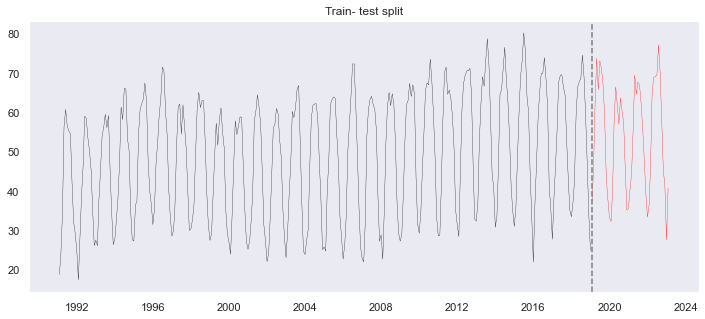

In [34]:
train_df = monthly_o3[monthly_o3.datetime < "2019-01-01 00:00:00"]
test_df = monthly_o3[monthly_o3.datetime > "2019-01-01 00:00:00"]

fig, ax = plt.subplots()
fig.set_size_inches((12,5))
ax.plot(train_df.datetime, train_df.value, color='black',linewidth=0.3)
ax.plot(test_df.datetime, test_df.value, color="red",linewidth=0.3)
ax.axvline(x=test_df.datetime.iloc[0], color='gray', linestyle='--', label='train-test-split')
ax.set_title("Train- test split");

In [35]:
x_train = train_df[categorical_features]
y_train = train_df[target]
x_test = test_df[categorical_features]
y_test = test_df[target]

model = HistGradientBoostingRegressor(loss="squared_error",
                                      learning_rate=0.05,
                                        validation_fraction=0.15,
                                        max_iter=200)

model.fit(x_train,y_train)
print(f"Test score R2: {model.score(x_test,y_test)}")

Test score R2: 0.7500886598962917


Text(0.5, 1.0, 'Forecast of Mean O3 levels from 2023/01/01 00:00:00 to 2024/12/12 00:00:00')

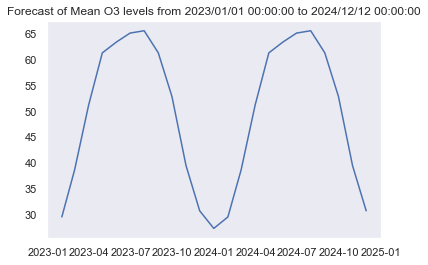

In [36]:
## hourly predictions

start_date = "2023/01/01 00:00:00"
end_date = "2024/12/12 00:00:00"

dates = pd.date_range(start=start_date,
              end=end_date,
              freq="M")

df_forecast = pd.DataFrame(dates,columns=["datetime"])

# add datime columns
df_forecast["month"] = df_forecast["datetime"].dt.month
df_forecast["year"] = df_forecast["datetime"].dt.year


df_forecast["O3_forecast"] = model.predict(df_forecast[categorical_features])
plt.plot(df_forecast["datetime"].values,df_forecast["O3_forecast"].values)
plt.title(f"Forecast of Mean O3 levels from {start_date} to {end_date}")

# Conclusions

* Air quality patterns for different pollutants have seasonal dependencies and even interactions within them. 
* O3 levels on Catalonia on average are rising, but it's true that in the past there were not data available for all points. As number of stations increase the stakeholders could have a better picture of the Air pollution. 
* Other Air contaminants like NO2, SO2, PM10 and PM2.5 are following a downward trend that could be the result of the sustainability measures taken by the local governement.
* OCEAN Protocol is providing a really interesting functionality to access data keeping the privacy and allowing the data scientist to begin a business model with thir developed models. 

# Limitations

* The models developed here don't take information from past observations, however for the chosen pollutant it's clear that the time behaviour could be modelled using the present values and for the sake of explainability this type of model could be coupled in the future with autoregresive features to improve the accuracy while maintining the effect of exogenus variables.